In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from lifelines.datasets import load_rossi

plt.style.use('bmh')

## Assesing Cox model fit using residuals (work in progress)

This tutorial is on some common use cases of the (many) residuals of the Cox model. We can use resdiuals to diagnose a model's poor fit to a dataset, and improve an existing model's fit. 

In [17]:
df = load_rossi()

df['age_strata'] = pd.cut(df['age'], np.arange(0, 80, 5))
df = df.drop('age', axis=1)

cph = CoxPHFitter()
cph.fit(df, 'week', 'arrest', strata=['age_strata', 'wexp'])

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
            strata = ['age_strata', 'wexp']
number of subjects = 432
  number of events = 114
    log-likelihood = -434.50
  time fit was run = 2019-01-01 14:19:19 UTC

---
      coef  exp(coef)  se(coef)     z      p  log(p)  lower 0.95  upper 0.95   
fin  -0.41       0.67      0.19 -2.10   0.04   -3.34       -0.79       -0.03  .
race  0.29       1.33      0.31  0.93   0.35   -1.04       -0.32        0.90   
mar  -0.34       0.71      0.39 -0.87   0.38   -0.96       -1.10        0.42   
paro -0.10       0.91      0.20 -0.50   0.62   -0.48       -0.48        0.29   
prio  0.08       1.08      0.03  2.83 <0.005   -5.36        0.02        0.14  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1

Concordance = 0.61
Likelihood ratio test = 481.75 on 5 df, log(p)=-232.93


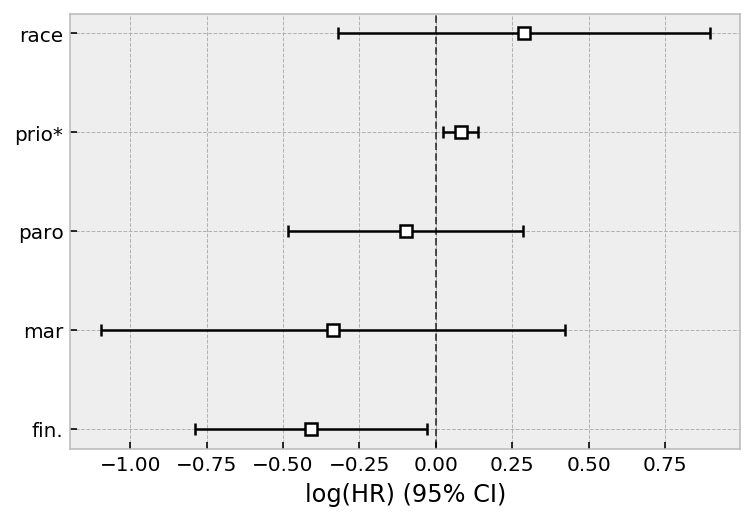

In [18]:
cph.print_summary()
cph.plot();

### Martingale residuals

Defined as:

$$ \delta_i - \Lambda(T_i) \\ = \delta_i - \beta_0(T_i)\exp(\beta^T x_i)$$

where $T_i$ is the total observation time of subject $i$ and $\delta_i$ denotes whether they died under observation of not (`event_observed` in _lifelines_). 

From [1]:

> Martingale residuals take a value between $[1,−\inf]$ for uncensored observations and $[0,−\inf]$ for censored observations. Martingale residuals can be used to assess the true functional form of a particular covariate (Thernau et al. (1990)). It is often useful to overlay a LOESS curve over this plot as they can be noisy in plots with lots of observations. Martingale residuals can also be used to assess outliers in the data set whereby the survivor function predicts an event either too early or too late, however, it's often better to use the deviance residual for this.

From [2]:

> Positive values mean that the patient died sooner than
expected (according to the model); negative values mean that
the patient lived longer than expected (or were censored).

In [19]:
r = cph.compute_residuals(df, 'martingale')
r.head()

,week,arrest,martingale
313,1.0,True,0.989383
79,5.0,True,0.972812
60,6.0,True,0.947726
225,7.0,True,0.976976
138,8.0,True,0.920272


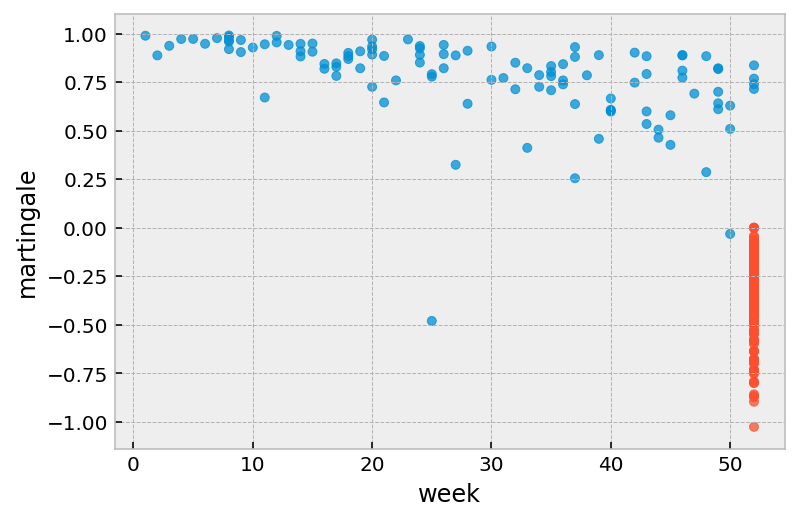

In [20]:
r.plot.scatter(
    x='week', y='martingale', c=np.where(r['arrest'], '#008fd5', '#fc4f30'),
    alpha=0.75
)

### Deviance residuals

One problem with martingale residuals is that they are not symetric around 0. Deviance residuals are a transform of martingale residuals them symetric. 

- Roughly symmetric around zero, with approximate standard deviation equal to 1.
- Positive values mean that the patient died sooner than expected.
- Negative values mean that the patient lived longer than expected (or were censored).
- Very large or small values are likely outliers.


In [21]:
r = cph.compute_residuals(df, 'deviance')
r.head()

,week,arrest,deviance
313,1.0,True,2.666812
79,5.0,True,2.294414
60,6.0,True,2.001769
225,7.0,True,2.364001
138,8.0,True,1.793799


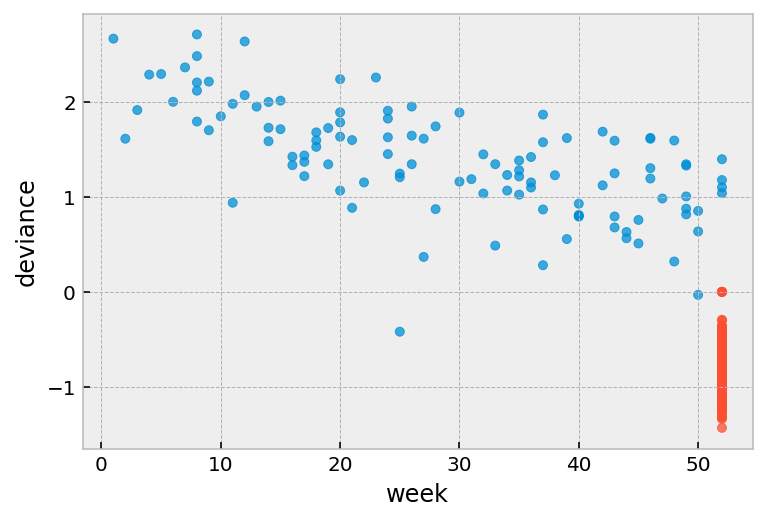

In [22]:
r.plot.scatter(
    x='week', y='deviance', c=np.where(r['arrest'], '#008fd5', '#fc4f30'),
    alpha=0.75
)

In [23]:
r = r.join(df.drop(['week', 'arrest'], axis=1))

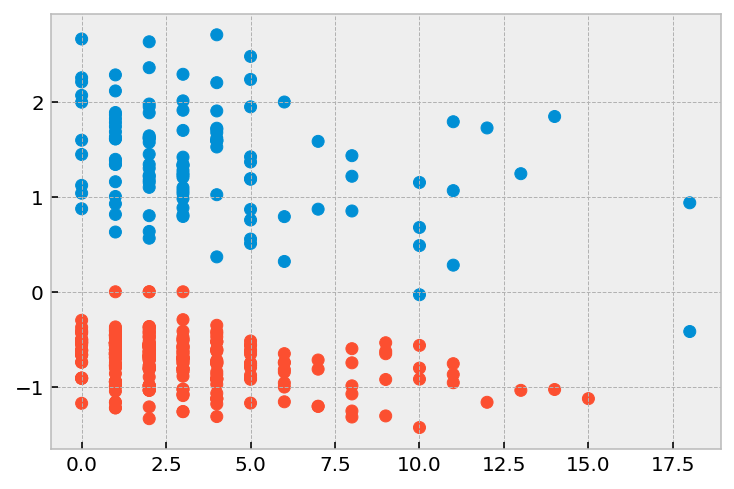

In [26]:
plt.scatter(r['prio'], r['deviance'], color=np.where(r['arrest'], '#008fd5', '#fc4f30'))

In [32]:
r = cph.compute_residuals(df, 'delta_beta')
r.head()
r = r.join(df[['week', 'arrest']])
r.head()

,fin,race,mar,paro,prio,week,arrest
313,-0.005651,-0.011591,0.012141,-0.027451,-0.020482,1,1
79,-0.005761,-0.005809,0.007687,-0.020926,-0.013370,5,1
60,-0.005783,-0.000146,0.003277,-0.014325,-0.006314,6,1
225,0.014998,-0.041566,0.004854,-0.002255,-0.015722,7,1
138,0.011573,0.005330,-0.004240,0.013036,0.004404,8,1


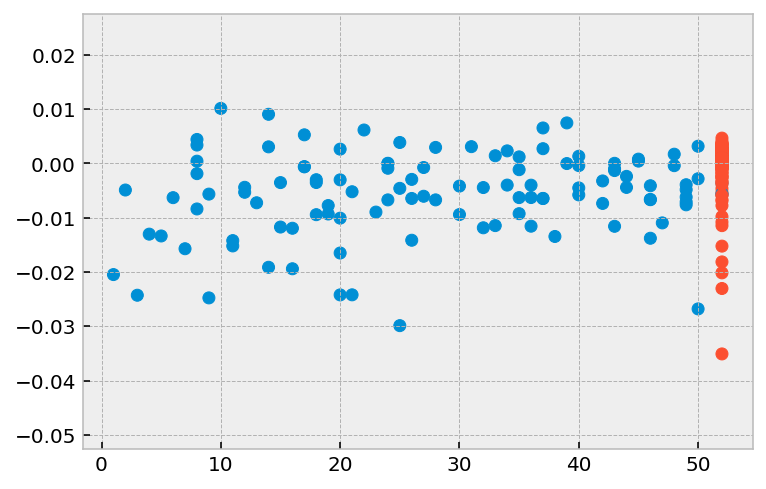

In [38]:
plt.scatter(r['week'], r['prio'], color=np.where(r['arrest'], '#008fd5', '#fc4f30'))

[1] https://stats.stackexchange.com/questions/297740/what-is-the-difference-between-the-different-residuals-in-survival-analysis-cox

[2] http://myweb.uiowa.edu/pbreheny/7210/f15/notes/11-10.pdf